<a href="https://colab.research.google.com/github/pimpul/MR-Physics-with-Pulseq/blob/main/tutorials/01_basic_sequences/notebooks/01_fid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Free induction decay (FID) sequence
FID is the simpliest sequence but this does not mean it is not important:) Now, let's build FID together and kick off the Pulseq game in Colab!   
**Exercise**:
1. Go through the whole sequence source code and then run it to get familiar with Pulseq programming in Google CoLab.
2. Observe the simulated signal and the reconstructed spectrum. Why do we see only a **decay** and not a damped oscillation in the simulated signal? Change the delay of the RF pulse to make the ADC start at 12 ms. Hint: use calc_duration to get the duration of the RF pulse (pp.calc_duration(rf_ex)).
3. Change the **flip angle**, α, and find the flip angle for maximum signal amplitude, S_max. Guess the function S(α).
4. Search for the B0 inhomogeneity of the object (*dB0*). In the on-resonant case this is 0. By changing the value (e.g. *dB0*  = 500), you can mimic the **laboratory frame dynamic** and observe a frequency shift in the reconstructed 1D spectrum.
5. Is the decay of the FID given by T1, T2, or T2*? Estimate the numerical value of the decay rate R (or relaxation time T=1/R) of the FID signal.
6. Set *dB0*=0 and alter the RF phase offset and ADC phase offset. What do you observe? What is the most general condition to get a real positive signal?
7. (optional) Repeat the FID sequence multiple times, add a T1 recovery time delay (Trec) of 1 s after each ADC. Why is the first signal higher than all the others?
8. (optional) Cover a range of different Trec in one measurement from 0.1 to 3 s. what is the recovery rate R or recovery time T? T1, T2, or T2*?


In [3]:
#@title 1D FID in a pixel phantom - environment setup
!pip install git+https://github.com/FrankZijlstra/pypulseq.git
#!pip install git+https://github.com/imr-framework/pypulseq.git
!wget https://raw.githubusercontent.com/pulseq/MR-Physics-with-Pulseq/main/utils/utils.py &> /dev/null
import math
import warnings
import numpy as np
from matplotlib import pyplot as plt
import pypulseq as mr
# for simulation
!pip show MRzeroCore || pip install MRzeroCore
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/util.py &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null
!pip install sigpy
import utils # several helper functions for simulation and recon
import MRzeroCore as mr0

  Cloning https://github.com/FrankZijlstra/pypulseq.git to /tmp/pip-req-build-n65972d3
  Running command git clone --filter=blob:none --quiet https://github.com/FrankZijlstra/pypulseq.git /tmp/pip-req-build-n65972d3
  Resolved https://github.com/FrankZijlstra/pypulseq.git to commit 7b2377663463e3f2ac960adfad26c81b80510f5f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Name: MRzeroCore
Version: 0.3.13
Summary: Core functionality of MRzero
Home-page: 
Author: 
Author-email: Jonathan Endres <jonathan.endres@uk-erlangen.de>
License: 
Location: /usr/local/lib/python3.11/dist-packages
Requires: matplotlib, pydisseqt, pypulseq, requests, scikit-image, scipy, torch, torchkbnufft
Required-by: 
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.7/108.7 kB 2.8 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/sigpy/config.py:27: UserWarning: Importing cupy.cuda.cudnn failed. For more details, see the error stack below:
libcudnn.so.8: cannot open shared object file: No such file or directory
  warnings.warn(


Timing check passed successfully


<ipython-input-4-db3f9b9f79e9>:21: UserWarning: Specified ADC delay 0.00 us is less than the dead time 20 us. Delay was increased to the dead time.
  adc = mr.make_adc(num_samples=Nread, duration=51.2e-3, phase_offset=0*np.pi/180, delay=0e-3, system=system)


'96ec3df3643100fa7c76107a6e94e626'

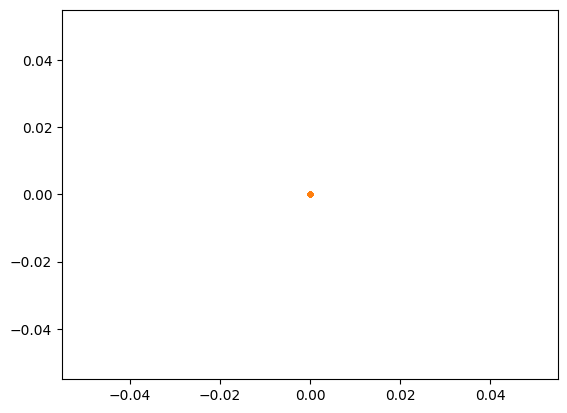

In [4]:
#@title FID in a pixel phantom - sequence
# %% DEFINE the sequence, FOV and resolution
Nread=256
Nrep=1 # repeat the fid sequence mutiple times

experiment_id = 'fid'
# %% SETUP system
# choose the scanner limits
system = mr.Opts(
    max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
    rf_ringdown_time=20e-6, rf_dead_time=100e-6,
    adc_dead_time=20e-6, grad_raster_time=50 * 10e-6)
seq=mr.Sequence(system)

# Define rf event
# hard pulse for excitation
rf_ex = mr.make_block_pulse(flip_angle=90*np.pi/180, duration=1e-3, phase_offset=0*np.pi/180, delay=0e-3, system=system)
#rf_ex.delay = 12e-3 - mr.calc_duration(rf_ex) # create a delay to make ADC start at 12 ms.

# Define ADC event
adc = mr.make_adc(num_samples=Nread, duration=51.2e-3, phase_offset=0*np.pi/180, delay=0e-3, system=system)

#Trec=3 # set the recovery time
# ======
# CONSTRUCT SEQUENCE
# ======
for i in range(Nrep):
  seq.add_block(rf_ex)
  seq.add_block(adc)
  #seq.add_block(mr.make_delay(Trec)) # add a recovery delay here

(ok, error_report) = seq.check_timing()  # Check whether the timing of the sequence is correct
if ok:
    print("Timing check passed successfully")
else:
    print("Timing check failed. Error listing follows:")
    [print(e) for e in error_report]

# Plot k-space trajectory
k_traj_adc, k_traj, t_excitation, t_refocusing, t_adc = seq.calculate_kspace()

plt.figure()
plt.plot(k_traj[0],k_traj[1])
plt.plot(k_traj_adc[0],k_traj_adc[1],'.')

# Prepare the sequence output for the scanner
seq.set_definition('Name', 'fid')
seq.write('01_fid.seq')

CustomVoxelPhantom
Voxel shape: box
Voxel size: tensor([0.1000, 0.1000, 0.1000])


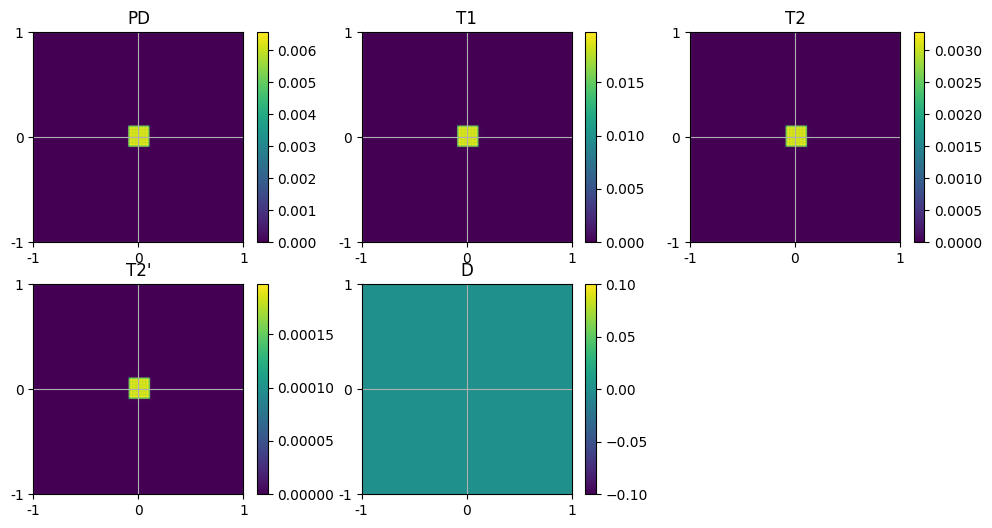

Calculating repetition 1 / 1 - done


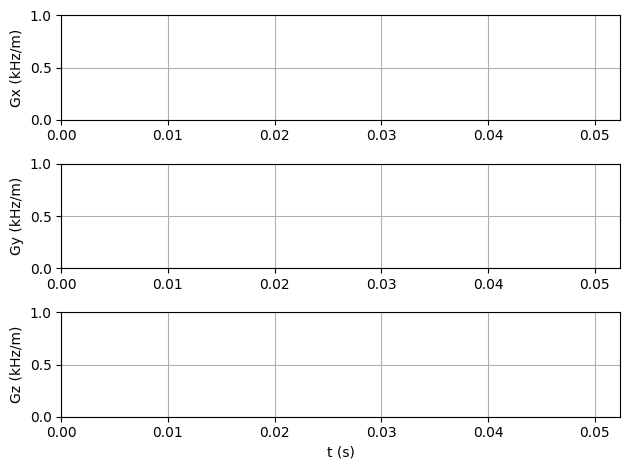

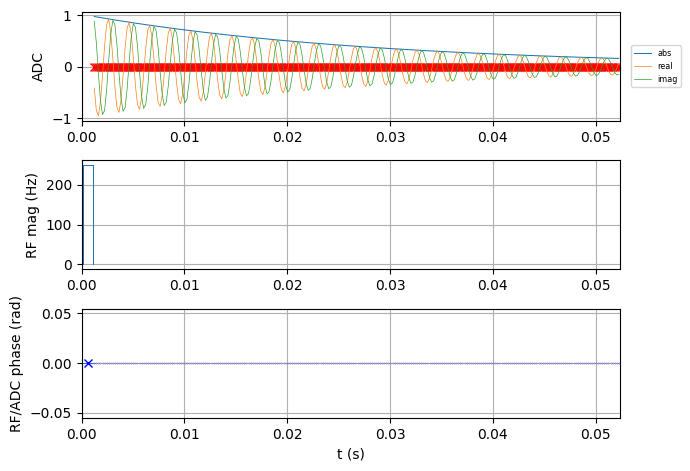

In [7]:
#@title FID in a pixel phantom - simulation
#@markdown  The B0 inhomogeneity brings you from the rotating frame FID at dB0=0, closer to the lab frame FID at dB0=B0.
#@markdown Try dB0=0 and dB0=500 for a test.
dB0 = 500 #@param {title:'dB0',type:"slider", min:0, max:500, step:10}
# %% S4: SETUP SPIN SYSTEM/object on which we can run the MR sequence external.seq from above
# set phantom  manually to a pixel phantom. Coordinate system is [-0.5, 0.5]^3
obj_p = mr0.CustomVoxelPhantom(
        pos=[[0., 0., 0]],
        PD=[1.0],
        T1=[3.0],
        T2=[0.5],
        T2dash=[30e-3],
        D=[0.0],
        B0=0,
        voxel_size=0.1,
        voxel_shape="box"
    )
# Manipulate loaded data
obj_p.B0+=dB0
obj_p.D*=0
obj_p.plot()
# Convert Phantom into simulation data
obj_p=obj_p.build()

# %% SIMULATE  the external.seq file and add acquired signal to ADC plot
# Read in the sequence
seq0 = mr0.Sequence.import_file("01_fid.seq")
#seq0.plot_kspace_trajectory()
# Simulate the sequence
graph=mr0.compute_graph(seq0, obj_p, 200, 1e-3)
signal=mr0.execute_graph(graph, seq0, obj_p)
# PLOT sequence with signal in the ADC subplot
seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
plt.show()

<ipython-input-8-f24a4f65ff76>:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.plot(time_axis, np.abs(signal), label='abs')


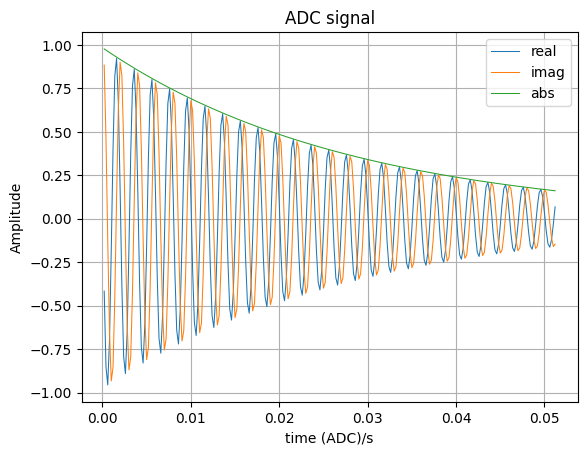

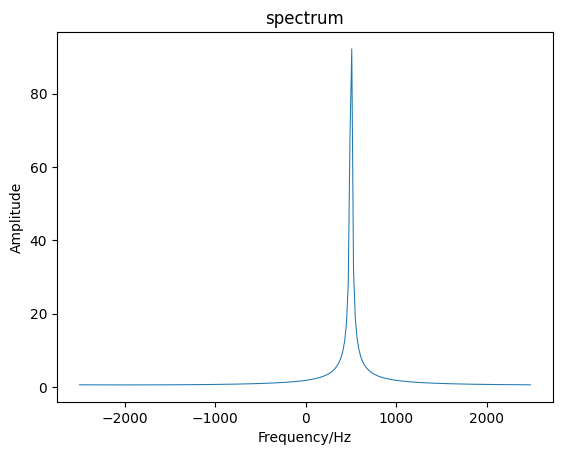

In [8]:
#@title FID in a pixel phantom - reconstruction
# 1D FFT
def fft_1d(x):
    return np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(x)))

# detailed ADC plot for one repetition
if Nrep==1:
  plt.figure()
  plt.title('ADC signal')
  # time axis
  time_axis=np.linspace(1, Nread, Nread)*adc.dwell ;
  plt.plot(time_axis, np.real(signal), label='real')
  plt.plot(time_axis, np.imag(signal), label='imag')
  plt.plot(time_axis, np.abs(signal), label='abs')
  plt.grid()
  plt.legend(loc="upper right")
  plt.xlabel('time (ADC)/s')
  plt.ylabel('Amplitude')

  # FFT reconstruction
  spectrum = fft_1d(signal)

  # frequency axis
  freq_axis = np.linspace(-Nread/2, Nread/2-1, Nread)/(adc.dwell*adc.num_samples) ; # remain to be checked whether -1 should be included or not

  plt.figure()
  plt.title('spectrum')
  plt.plot(freq_axis, np.abs(spectrum))
  plt.xlabel('Frequency/Hz')
  plt.ylabel('Amplitude')